In [ ]:
import os
from pathlib import Path
from operator import itemgetter
import pickle
import pydicom
import time

import matplotlib.pyplot as plt
import numpy as np
from shapely.affinity import translate

import CATCH_utils
from Mini_LL import *

In [ ]:
# Find images (Caseid, slice phase) with missing MYO
bp = '/media/omega/Daten1/CATCH/CS/Cases'
case_paths = [os.path.join(bp,p) for p in os.listdir(bp) if p.endswith('.pickle')]
cases = [pickle.load(open(p, 'rb')) for p in case_paths]

st = time()
nr_imgs_blas = 0
for c in cases:
    es_phase = [cat.phase for cat in c.categories if 'ES' in cat.name][0]
    ed_phase = [cat.phase for cat in c.categories if 'ED' in cat.name][0]
    cat = [cat for cat in c.categories if 'ES' in cat.name][0]
    print('Outer loop case: ', c.case_name)

    cat      = c.categories[0]
    for p in [es_phase, ed_phase]:
        for d in range(cat.nr_slices):
            img  = cat.get_img(d, p)
            h, w = img.shape
            anno = cat.get_anno(d, p)
            if anno.has_contour('lv_endo') and not anno.has_contour('lv_epi'):
                print('Case: ', c.case_name)
                print('Phase: ', p, ', Slice: ', d)
                mask = np.zeros((h,w,3))
                mask[:,:,0] = anno.get_cont_as_mask('lv_endo', h, w)
                mask[:,:,1] = anno.get_cont_as_mask('lv_epi',  h, w)
                mask[:,:,2] = anno.get_cont_as_mask('rv_endo', h, w)
                nr_imgs_blas += 1
                fig, ax = plt.subplots(1, 2, figsize=(7,7))
                ax[0].imshow(img, cmap='gray')
                ax[1].imshow(mask)
                plt.show()

    
print('Producing: ', nr_imgs_blas, ' takes: ', time()-st)

In [ ]:
import numpy as np

import imgaug as ia
from imgaug.augmentables.batches import UnnormalizedBatch
from imgaug import augmenters as iaa

In [ ]:
# custom z score augmenter
def func_images(images, random_state, parents, hooks):
    return [(image-np.mean(image)) / np.std(image) for image in images]
def func_polygons(polygons_on_images, random_state, parents, hooks):
    return polygons_on_images
custom_zscore_augmenter = iaa.Lambda(func_images=func_images, func_polygons=func_polygons)


# No New Unet augmentations, order is important 
aug = iaa.Sequential([
    iaa.PadToFixedSize(width=360, height=360, position='center', pad_mode=["linear_ramp"]), #constant, edge, linear_ramp, maximum, median, minimum, reflect, symmetric, wrap
    iaa.Sometimes(0.4, iaa.Affine(rotate = (-120, 120), scale = {"x": (0.8, 1.2), "y": (0.8, 1.2)})),      # rotation and scaling performed quite often
    iaa.Sometimes(0.3, iaa.Affine(translate_percent={"x": (-0.07, 0.07), "y": (-0.07, 0.07)}, shear=(-4, 4))), # translation and shearing occurs, but not as often
    iaa.CropToFixedSize(width=256, height=256, position='center'),
    custom_zscore_augmenter,                                                  # a custom zscore is applied (see above) after cropping, otherwise the means/variances are distorted significantly
    iaa.Sometimes(0.12, iaa.AveragePooling(((1, 2), (1, 2)))),                # average pooling mimics a downsampling of the x or y axis
    iaa.Sometimes(0.12, iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.07))), # some noise, 0.2 definitely too high, 0.05 not visible, 0.07 looks good
    iaa.Sometimes(0.12, iaa.GaussianBlur(sigma=(0, 1.5))),                    # weak blur and occasionally (1.5% of cases) strong blur
    iaa.Sometimes(0.2, iaa.Multiply((0.7, 1.3))),                             # brightness 
    iaa.Sometimes(0.15, iaa.LinearContrast((0.7, 1.4))),                      # contrast augmentation
], random_order=False)                                                        # apply augmenters in random order



# No New Unet augmentations, order is important 
no_aug = iaa.Sequential([
    iaa.PadToFixedSize(width=360, height=360, position='center', pad_mode=["linear_ramp"]), #constant, edge, linear_ramp, maximum, median, minimum, reflect, symmetric, wrap
    iaa.CropToFixedSize(width=256, height=256, position='center'),
    custom_zscore_augmenter,                                                  # a custom zscore is applied (see above) after cropping, 
], random_order=False)                                                        # apply augmenters in random order



In [ ]:
import math
import matplotlib.pyplot as plt

from tensorflow.keras.utils import Sequence

import imgaug
import time
import cv2

In [38]:
class CatchGenerator(Sequence):
    def __init__(self, basepath, epochs_max, batch_size, k, k_max, img_h, img_w, provide_validation_set, aug, no_aug):
        self.basepath = basepath
        case_paths = [p for p in os.listdir(self.basepath) if p.endswith('.pickle')]
        self.cases = [pickle.load(open(os.path.join(basepath, fname), 'rb')) for fname in case_paths]
        self.tr_cases, self.val_cases = self.get_kcross_datasets(self.cases, k, k_max)
        self.epochs_max = epochs_max
        self.batch_size = batch_size
        self.img_h, self.img_w = img_h, img_w
        self.aug    = aug
        self.no_aug = no_aug
        self.anno = self.cases[0].categories[0].get_anno(0,0)
        self.k, self.k_max = k, k_max
        self.provide_validation_set = provide_validation_set
        self.gen = self._multiprocessing_augmented_batches()
        
        
    def __len__(self):
        cases = self.val_cases if self.provide_validation_set else self.tr_cases
        return math.ceil(sum(case.categories[0].nr_phases for case in cases) / self.batch_size)
        
    def get_kcross_datasets(self, cases, k, k_max):
        n           = len(cases)
        k_nr        = n // k_max
        train_cases = cases[:k*k_nr] + cases[(k+1)*k_nr:]
        val_cases   = cases[k*k_nr:(k+1)*k_nr]
        return train_cases, val_cases
    
    def _unaugmented_batch(self):
        scale = 1.5
        cases = self.val_cases if self.provide_validation_set else self.tr_cases
        imgs, polys = [], []
        for i in range(self.batch_size):
            r_case  = np.random.randint(0, len(cases))
            case    = cases[r_case]
            cat     = [c for c in case.categories][np.random.randint(0, len(case.categories))]
            d       = np.random.randint(0, cat.nr_slices)
            p       = cat.get_phase()
            #print('Stuff from: ', case.case_name, d, p, list(case.annos_sop2filepath.values())[0])
            img     = cat.get_img(d, p).astype(np.float32)
            h, w    = img.shape
            img     = cv2.resize(img,  (int(np.round(w*scale)), int(np.round(h*scale))), interpolation=cv2.INTER_CUBIC)
            anno    = cat.get_anno(d, p)
            lv_endo = imgaug.augmentables.polys.Polygon(np.array(anno.get_contour('lv_endo').exterior.coords) * scale, 'lv_endo') if anno.has_contour('lv_endo') else None
            if anno.has_contour('lv_epi'): epi_coords = anno.get_contour('lv_epi').exterior.coords if hasattr(anno.get_contour('lv_epi'), 'exterior') else anno.get_contour('lv_epi').coords
            lv_epi  = imgaug.augmentables.polys.Polygon(np.array(epi_coords)  * scale, 'lv_epi')  if anno.has_contour('lv_epi')  else None
            rv_endo = imgaug.augmentables.polys.Polygon(np.array(anno.get_contour('rv_endo').exterior.coords) * scale, 'rv_endo') if anno.has_contour('rv_endo') else None
            poly    = [c for c in [lv_endo, lv_epi, rv_endo] if c]
            imgs.append(img); polys.append(poly)
        return imgs, polys
    
    def _make_unaugmented_batch(self, imgs, polys):
        batch = UnnormalizedBatch(images=imgs, polygons=polys)
        return batch
    
    def _unaugmented_batch_generator(self):
        for i in range(len(self)+1):
            imgs, polys = self._unaugmented_batch()
            batch = self._make_unaugmented_batch(imgs, polys)
            yield batch
            
    def _multiprocessing_augmented_batches(self):
        aug       = self.no_aug if self.provide_validation_set else self.aug
        generator = self._unaugmented_batch_generator()
        anno      = self.anno
        with aug.pool(processes=-2, seed=1, maxtasksperchild=1000) as pool:
            batches_aug = pool.imap_batches(generator, output_buffer_size=5)
            for i in range(len(self)+1):
                augmented_batch = next(batches_aug)
                img_batch, poly_batch = augmented_batch.images_aug, augmented_batch.polygons_aug
                mask_batch = []
                for j in range(len(poly_batch)):
                    polys = poly_batch[j]
                    mask = np.zeros((self.img_h, self.img_w, 3))
                    mask[:,:,0] = anno.get_mask([polys[0]], self.img_h, self.img_w)
                    mask[:,:,1] = anno.get_mask([polys[1]], self.img_h, self.img_w) - anno.get_mask([polys[0]], self.img_h, self.img_w, outline_val=0)
                    mask[:,:,2] = anno.get_mask([polys[2]], self.img_h, self.img_w)
                    mask_batch.append(mask)
                mask_batch = np.asarray(mask_batch)
                yield img_batch, mask_batch
                

    def __getitem__(self, index):
        img_batch, mask_batch = next(self.gen)
        return (np.asarray(img_batch), np.asarray(mask_batch))
        
    def on_epoch_end(self):
        self.gen = self._multiprocessing_augmented_batches()

In [46]:
bp = '/media/omega/Daten1/CATCH/CS/Cases'
epochs_max = 100
batch_size = 8
k = 0
k_max = 5
img_h, img_w = 200, 200
provide_validation_set=False
aug = aug
no_aug = no_aug

gen = CatchGenerator(bp, epochs_max, batch_size, k, k_max, img_h, img_w, provide_validation_set, aug, no_aug)


In [47]:
imgs, polys = gen._unaugmented_batch()
aug_imgs, aug_polys = aug(images=imgs, polygons=polys)

Stuff from:  ECSPRESS-111 6 9 /media/omega/Daten1/CATCH/CS/Annos/1.2.276.0.7230010.3.1.2.0.458.1575886001.564788/1.2.276.0.7230010.3.1.4.0.458.1575886008.565848.pickle
Stuff from:  ECSPRESS-033 0 10 /media/omega/Daten1/CATCH/CS/Annos/1.2.276.0.7230010.3.1.2.0.458.1575884078.404950/1.2.276.0.7230010.3.1.4.0.458.1575884081.405377.pickle
Stuff from:  ECSPRESS142 1 10 /media/omega/Daten1/CATCH/CS/Annos/1.2.276.0.7230010.3.1.2.0.530.1584971377.511158/1.2.276.0.7230010.3.1.4.0.530.1584971390.512983.pickle
Stuff from:  ECSPRESS-044 15 9 /media/omega/Daten1/CATCH/CS/Annos/1.2.276.0.7230010.3.1.2.0.458.1575884331.426180/1.2.276.0.7230010.3.1.4.0.458.1575884337.427135.pickle
Stuff from:  ECSPRESS-029 7 24 /media/omega/Daten1/CATCH/CS/Annos/1.2.276.0.7230010.3.1.2.0.458.1575883989.396929/1.2.276.0.7230010.3.1.4.0.458.1575883998.398271.pickle
Stuff from:  ECSPRESS-046 13 24 /media/omega/Daten1/CATCH/CS/Annos/1.2.276.0.7230010.3.1.2.0.458.1575884381.430357/1.2.276.0.7230010.3.1.4.0.458.1575884383.4

0
Stuff from:  ECSPRESS-088 8 24 /media/omega/Daten1/CATCH/CS/Annos/1.2.276.0.7230010.3.1.2.0.458.1575885472.520580/1.2.276.0.7230010.3.1.4.0.458.1575885481.521868.pickle
Stuff from:  ECSPRESS-068 3 11 /media/omega/Daten1/CATCH/CS/Annos/1.2.276.0.7230010.3.1.2.0.458.1575884906.473885/1.2.276.0.7230010.3.1.4.0.458.1575884910.474559.pickle
Stuff from:  ECSPRESS-072 17 8 /media/omega/Daten1/CATCH/CS/Annos/1.2.276.0.7230010.3.1.2.0.458.1575885000.481569/1.2.276.0.7230010.3.1.4.0.458.1575885014.483674.pickle
Stuff from:  ECSPRESS-001 14 24 /media/omega/Daten1/CATCH/CS/Annos/1.2.276.0.7230010.3.1.2.0.458.1575883389.343790/1.2.276.0.7230010.3.1.4.0.458.1575883397.344929.pickle
Stuff from:  ECSPRESS-077 7 24 /media/omega/Daten1/CATCH/CS/Annos/1.2.276.0.7230010.3.1.2.0.458.1575885123.491763/1.2.276.0.7230010.3.1.4.0.458.1575885129.492573.pickle
Stuff from:  ECSPRESS-119 4 0 /media/omega/Daten1/CATCH/CS/Annos/1.2.276.0.7230010.3.1.2.0.458.1575886295.588892/1.2.276.0.7230010.3.1.4.0.458.157588629

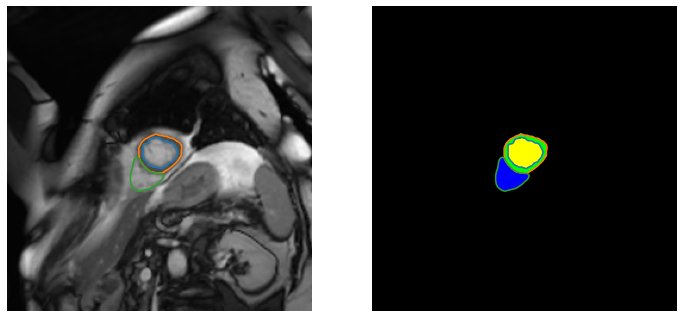

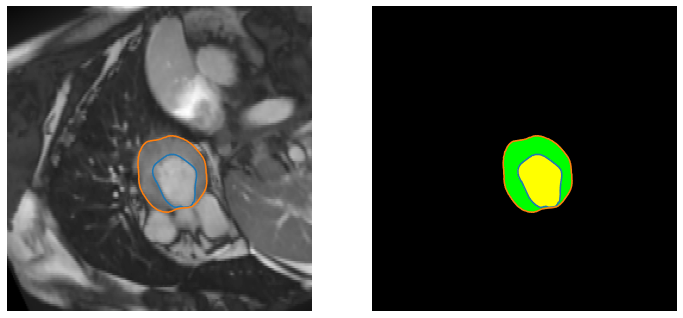

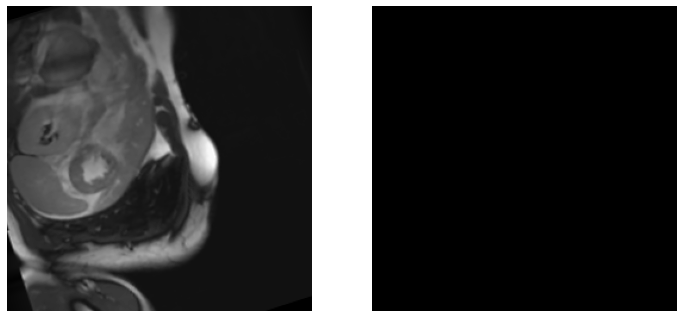

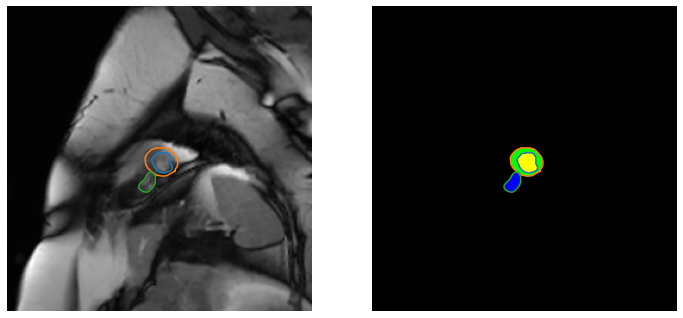

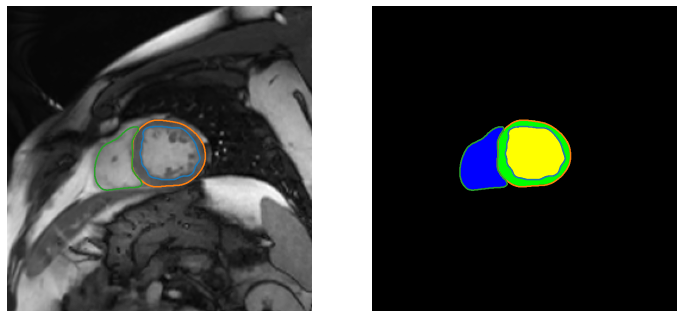

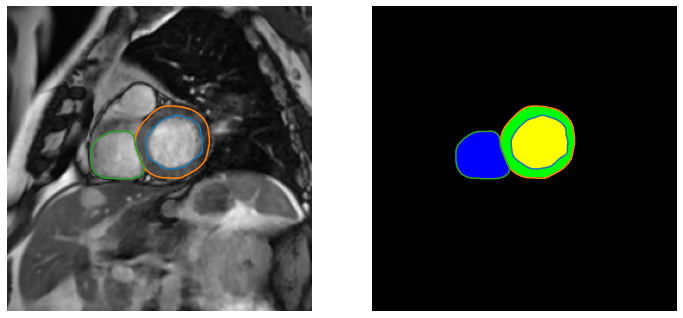

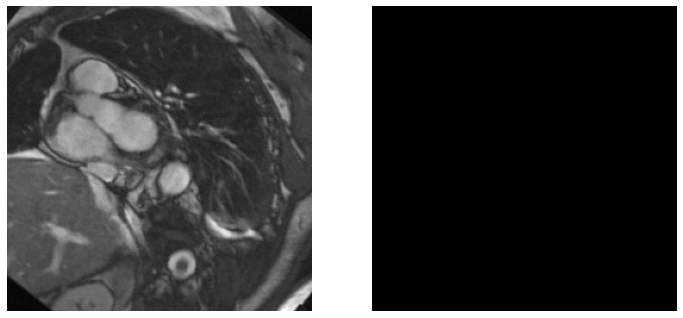

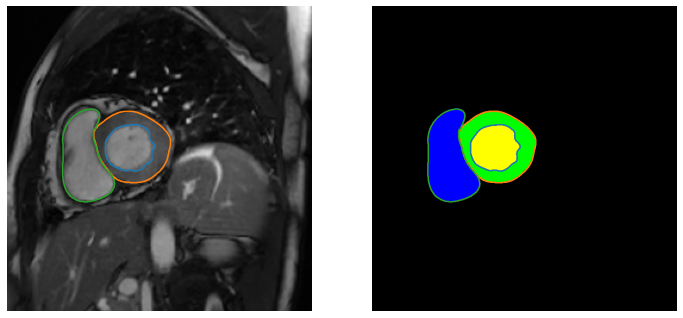

1
Stuff from:  ECSPRESS-111 9 24 /media/omega/Daten1/CATCH/CS/Annos/1.2.276.0.7230010.3.1.2.0.458.1575886001.564788/1.2.276.0.7230010.3.1.4.0.458.1575886008.565848.pickle
Stuff from:  ECSPRESS-029 0 9 /media/omega/Daten1/CATCH/CS/Annos/1.2.276.0.7230010.3.1.2.0.458.1575883989.396929/1.2.276.0.7230010.3.1.4.0.458.1575883998.398271.pickle
Stuff from:  ECSPRESS136 0 24 /media/omega/Daten1/CATCH/CS/Annos/1.2.276.0.7230010.3.1.2.0.530.1584970181.499101/1.2.276.0.7230010.3.1.4.0.530.1584970194.501063.pickle
Stuff from:  ECSPRESS-105 12 24 /media/omega/Daten1/CATCH/CS/Annos/1.2.276.0.7230010.3.1.2.0.458.1575885875.554058/1.2.276.0.7230010.3.1.4.0.458.1575885880.554854.pickle
Stuff from:  ECSPRESS140 0 24 /media/omega/Daten1/CATCH/CS/Annos/1.2.276.0.7230010.3.1.2.0.530.1584971003.507344/1.2.276.0.7230010.3.1.4.0.530.1584971014.509140.pickle
Stuff from:  ECSPRESS-060 4 11 /media/omega/Daten1/CATCH/CS/Annos/1.2.276.0.7230010.3.1.2.0.458.1575884712.458000/1.2.276.0.7230010.3.1.4.0.458.1575884713.

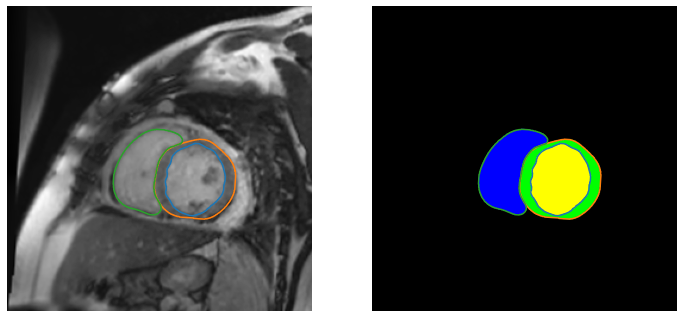

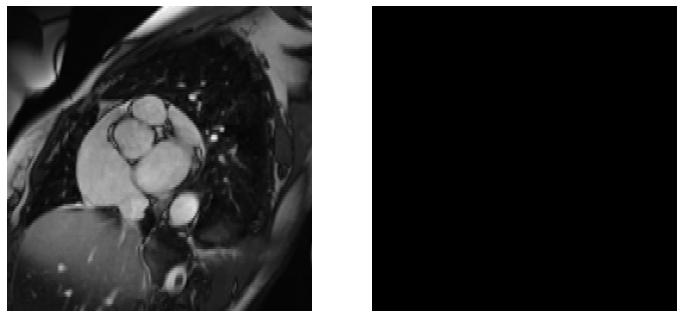

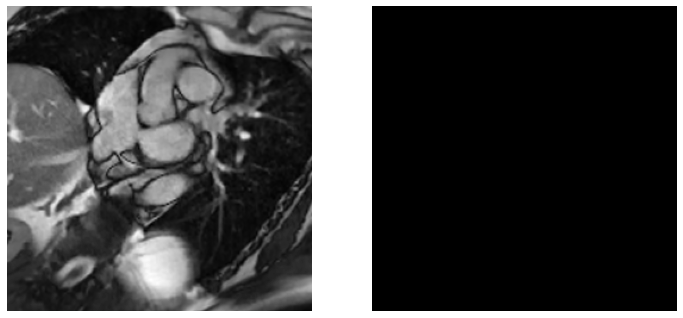

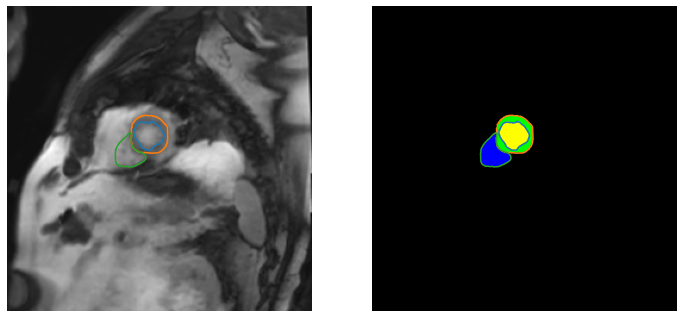

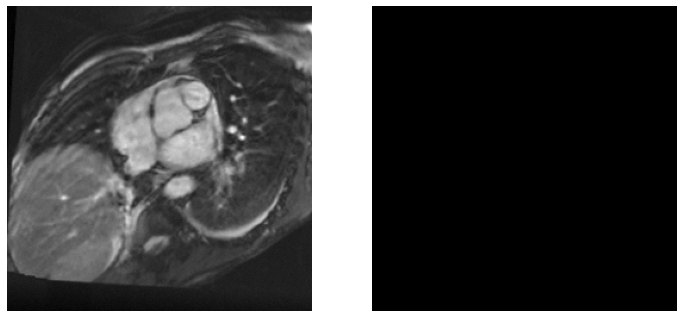

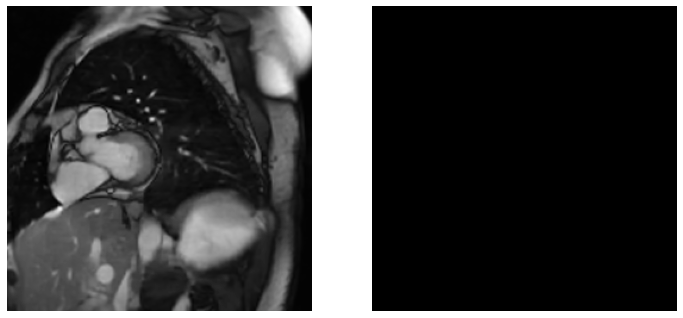

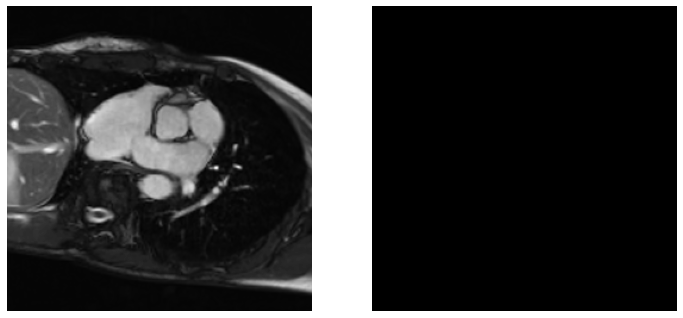

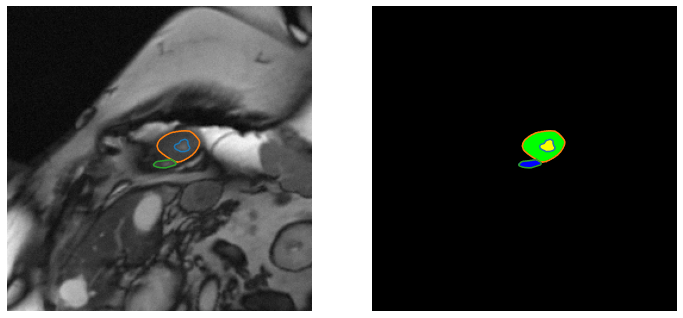

2
Stuff from:  ECSPRESS135 1 24 /media/omega/Daten1/CATCH/CS/Annos/1.2.276.0.7230010.3.1.2.0.530.1584970050.497177/1.2.276.0.7230010.3.1.4.0.530.1584970055.497977.pickle
Stuff from:  ECSPRESS-048 9 24 /media/omega/Daten1/CATCH/CS/Annos/1.2.276.0.7230010.3.1.2.0.458.1575884427.434322/1.2.276.0.7230010.3.1.4.0.458.1575884427.434395.pickle
Stuff from:  ECSPRESS-097 12 8 /media/omega/Daten1/CATCH/CS/Annos/1.2.276.0.7230010.3.1.2.0.458.1575885696.539129/1.2.276.0.7230010.3.1.4.0.458.1575885708.540797.pickle
Stuff from:  ECSPRESS-075 18 0 /media/omega/Daten1/CATCH/CS/Annos/1.2.276.0.7230010.3.1.2.0.458.1575885070.487359/1.2.276.0.7230010.3.1.4.0.458.1575885084.489372.pickle
Stuff from:  ECSPRESS-039 0 24 /media/omega/Daten1/CATCH/CS/Annos/1.2.276.0.7230010.3.1.2.0.458.1575884209.416162/1.2.276.0.7230010.3.1.4.0.458.1575884216.417131.pickle
Stuff from:  ECSPRESS-044 14 24 /media/omega/Daten1/CATCH/CS/Annos/1.2.276.0.7230010.3.1.2.0.458.1575884331.426180/1.2.276.0.7230010.3.1.4.0.458.157588433

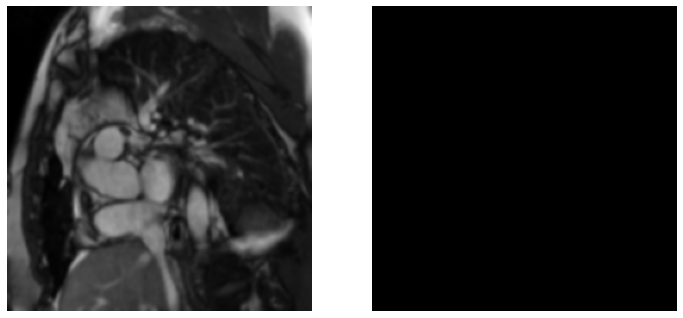

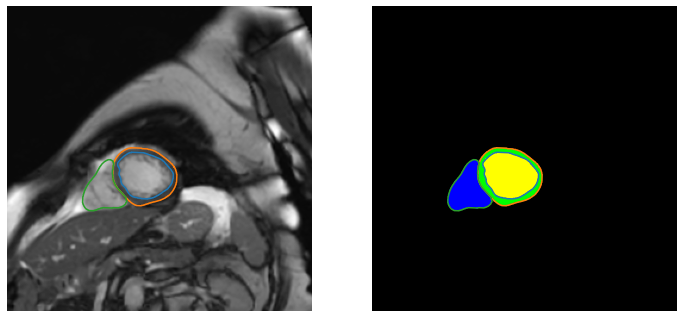

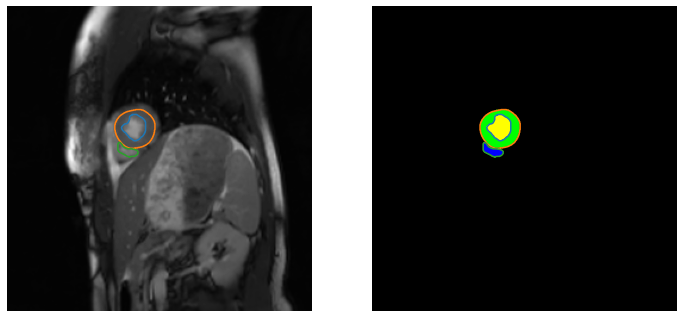

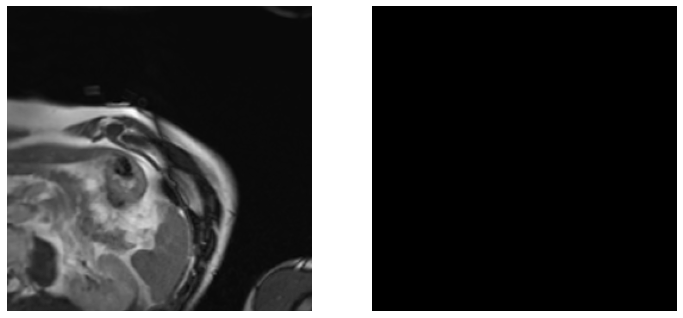

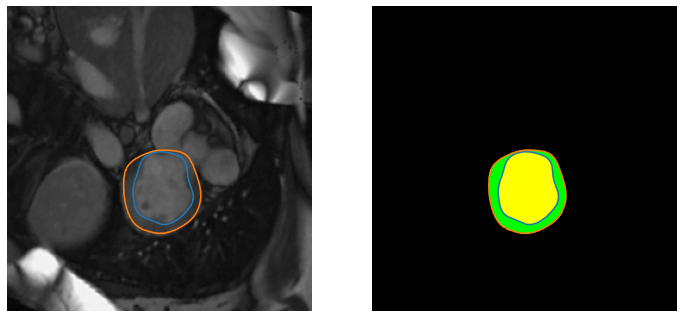

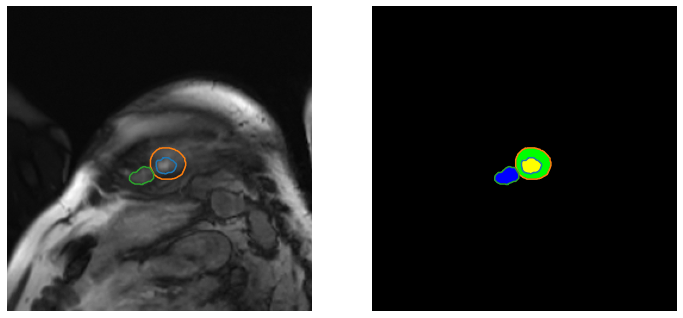

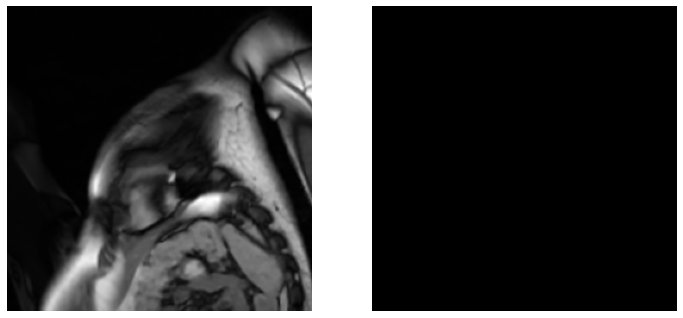

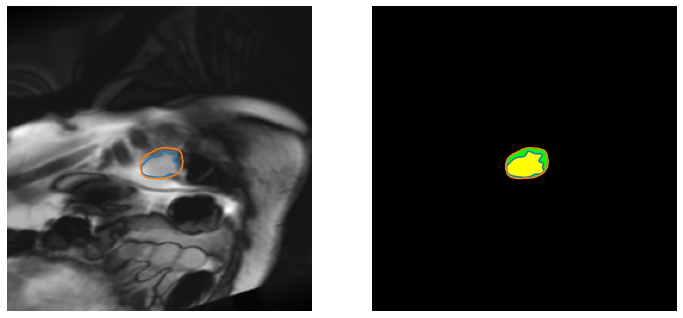

3
Stuff from:  ECSPRESS-018 12 24 /media/omega/Daten1/CATCH/CS/Annos/1.2.276.0.7230010.3.1.2.0.458.1575883742.375054/1.2.276.0.7230010.3.1.4.0.458.1575883755.376909.pickle
Stuff from:  ECSPRESS-058 5 24 /media/omega/Daten1/CATCH/CS/Annos/1.2.276.0.7230010.3.1.2.0.458.1575884667.454285/1.2.276.0.7230010.3.1.4.0.458.1575884675.455466.pickle
Stuff from:  ECSPRESS-119 15 10 /media/omega/Daten1/CATCH/CS/Annos/1.2.276.0.7230010.3.1.2.0.458.1575886295.588892/1.2.276.0.7230010.3.1.4.0.458.1575886298.589282.pickle
Stuff from:  ECSPRESS-042 9 24 /media/omega/Daten1/CATCH/CS/Annos/1.2.276.0.7230010.3.1.2.0.458.1575884281.422074/1.2.276.0.7230010.3.1.4.0.458.1575884296.424261.pickle
Stuff from:  ECSPRESS-010 11 12 /media/omega/Daten1/CATCH/CS/Annos/1.2.276.0.7230010.3.1.2.0.458.1575883567.359601/1.2.276.0.7230010.3.1.4.0.458.1575883569.359888.pickle
Stuff from:  ECSPRESS-108 3 9 /media/omega/Daten1/CATCH/CS/Annos/1.2.276.0.7230010.3.1.2.0.458.1575885940.559407/1.2.276.0.7230010.3.1.4.0.458.1575885

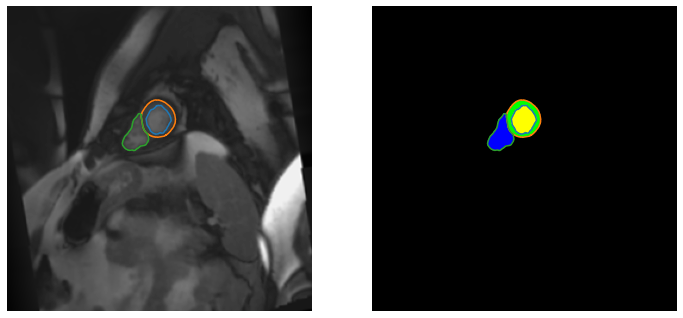

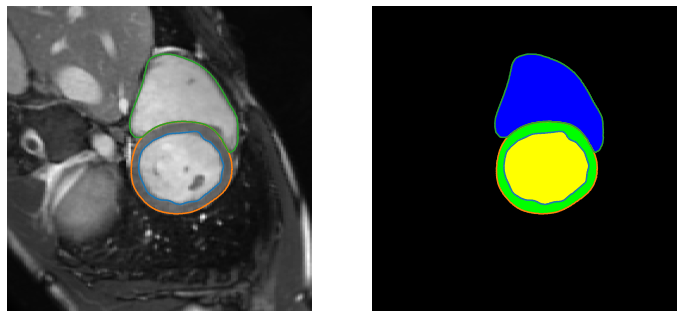

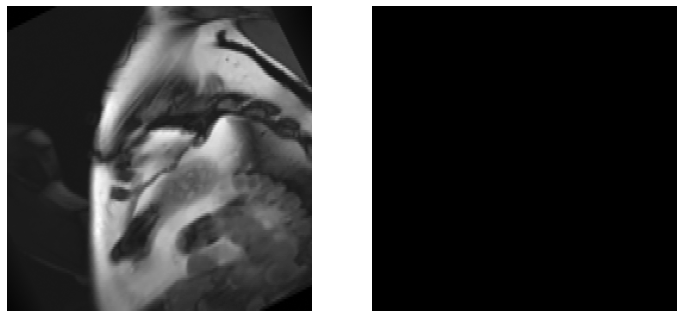

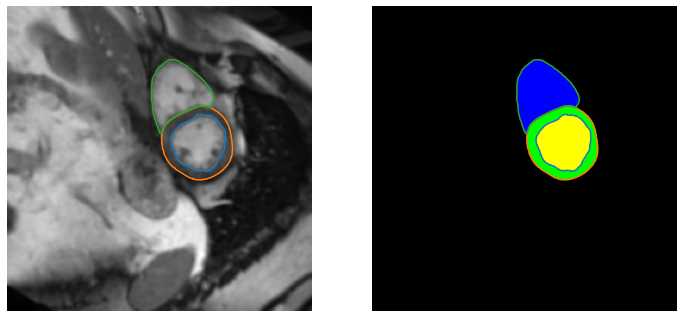

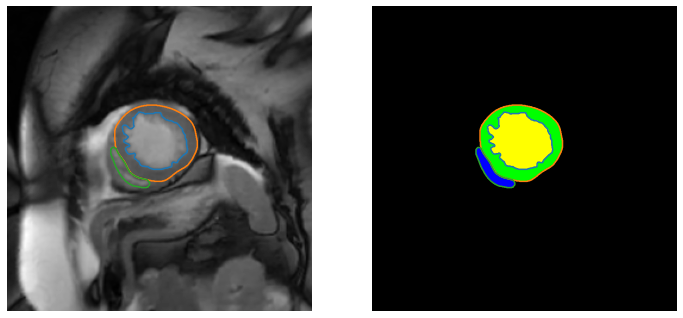

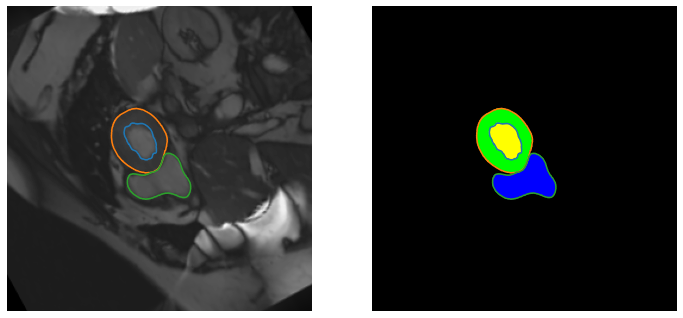

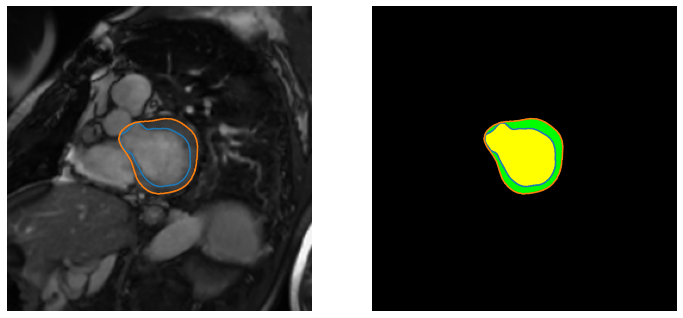

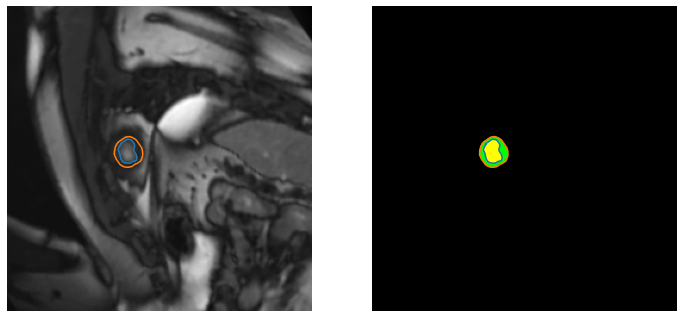

4
Stuff from:  ECSPRESS-061 1 10 /media/omega/Daten1/CATCH/CS/Annos/1.2.276.0.7230010.3.1.2.0.458.1575884736.459944/1.2.276.0.7230010.3.1.4.0.458.1575884739.460460.pickle
Stuff from:  ECSPRESS-094 7 10 /media/omega/Daten1/CATCH/CS/Annos/1.2.276.0.7230010.3.1.2.0.458.1575885629.533573/1.2.276.0.7230010.3.1.4.0.458.1575885638.534787.pickle
Stuff from:  ECSPRESS173 14 0 /media/omega/Daten1/CATCH/CS/Annos/1.3.6.1.4.1.53684.1.1.2.0.531.1590420784.148319/1.3.6.1.4.1.53684.1.1.4.0.531.1590420786.149197.pickle
Stuff from:  ECSPRESS-047 6 24 /media/omega/Daten1/CATCH/CS/Annos/1.2.276.0.7230010.3.1.2.0.458.1575884403.432191/1.2.276.0.7230010.3.1.4.0.458.1575884417.434252.pickle
Stuff from:  ECSPRESS-005 1 24 /media/omega/Daten1/CATCH/CS/Annos/1.2.276.0.7230010.3.1.2.0.458.1575883474.351296/1.2.276.0.7230010.3.1.4.0.458.1575883475.351502.pickle
Stuff from:  ECSPRESS-071 7 9 /media/omega/Daten1/CATCH/CS/Annos/1.2.276.0.7230010.3.1.2.0.458.1575884980.479902/1.2.276.0.7230010.3.1.4.0.458.1575884983.

KeyError: (12, nan)

In [48]:
for i in range(30):
    print(i)
    imgs, polys = gen._unaugmented_batch()
    aug_imgs, aug_polys = aug(images=imgs, polygons=polys)
    for j in range(len(aug_imgs)):
        height, width = aug_imgs[j].shape
        masks = np.zeros((height, width, 3))
        fig, axes = plt.subplots(1,2,figsize=(12,6))
        axes[0].imshow(aug_imgs[j], cmap='gray', extent=(0, width, height, 0))
        ps = aug_polys[j]
        for i_p, p in enumerate(ps):
            axes[0].plot([x[0] for x in p.exterior], [y[1] for y in p.exterior])
            axes[1].plot([x[0] for x in p.exterior], [y[1] for y in p.exterior])
            m_i = ['lv_endo','lv_epi','rv_endo'].index(p.label)
            masks[:,:,m_i] = CATCH_utils.to_mask(p.to_shapely_polygon(), height, width)
        axes[1].imshow(masks, extent=(0, width, height, 0))
        for ax in axes:
            ax.axis('scaled')
            ax.axis('off')
        plt.show()

In [ ]:
for i in range(300):
    print(i)
    imgs, polys = gen._unaugmented_batch()
    aug_imgs, aug_polys = aug(images=imgs, polygons=polys)
    for j in range(len(aug_imgs)):
        height, width = aug_imgs[j].shape
        ps = aug_polys[j]
        for i_p, p in enumerate(ps):
            
            x = [x[0] for x in p.exterior if x[0] > 256 or x[0] < 0]
            y = [x[1] for x in p.exterior if x[1] > 256 or x[1] < 0]
            
            if len(x) > 0 or len(y) > 0:
                print('                                      ZUUUUU GROSSSSS!!!', j)
            
            
            axes[0].plot([x[0] for x in p.exterior], [y[1] for y in p.exterior])
            axes[1].plot([x[0] for x in p.exterior], [y[1] for y in p.exterior])
            

In [ ]:
t1 = time.time()
getting_batches = 0
augmenting = 0
transforming = 0
for i in range(100):
    st = time.time()
    imgs, polys = gen._unaugmented_batch()
    getting_batches += time.time()-st
    st = time.time()
    aug_imgs, aug_polys = aug(images=imgs, polygons=polys)
    augmenting += time.time()-st
    st = time.time()
    for j in range(len(aug_imgs)):
        height, width = aug_imgs[j].shape
        masks = np.zeros((height, width, 3))
        ps = aug_polys[j]
        for i_p, p in enumerate(ps):
            m_i = ['lv_endo','lv_epi','rv_endo'].index(p.label)
            masks[:,:,m_i] = CATCH_utils.to_mask(p.to_shapely_polygon(), height, width)
    transforming += time.time()-st
print('Getting:      ', getting_batches)
print('Augmenting:   ', augmenting)
print('Transforming: ', transforming)
print('Alltogether:  ', time.time() - t1)